# Explorations in Generative Art
## Setup
### Extensions and Imports

In [1]:
:extension NoMonomorphismRestriction FlexibleContexts TypeFamilies
-- use FlexibleInstances & TypeSynonymInstances for making type instances
import Control.Monad
import Control.Monad.State

import System.Random
import Data.Random
import Data.RVar

import Diagrams.Prelude hiding (normal)
import Diagrams.Backend.Cairo -- for Cairo type constructor
import Data.Colour.Palette.BrewerSet
import qualified Diagrams.Color.XKCD as XKCD
import Data.Colour (withOpacity)

import Data.Tuple

### Useful functions

In [3]:
scanM :: (Monad m) => (a -> b -> m a) -> a -> [b] -> m [a]
scanM f q [] = return [q]
scanM f q (x:xs) =
   do q2 <- f q x
      qs <- scanM f q2 xs
      return (q:qs)

iterateM :: (Monad m) => Int -> (a -> m a) -> a -> m [a]
iterateM n f a = scanM (\x _ -> f x) a $ replicate n ()

-- example usage
incrementNegsOnly x = if x < 0 then Just (x + 1) else Nothing

iterateM 4 incrementNegsOnly (-4)
iterateM 4 incrementNegsOnly (-3)

Just [-4,-3,-2,-1,0]

Nothing

In [51]:
sampleAndDraw :: Int -- random seed
              -> RVar (QDiagram Cairo V2 Double Any) -- random diagram
              -> ManuallySized (QDiagram Cairo V2 Double Any) -- draws diagram
              
sampleAndDraw seed randomDiagram = withImgHeight 500 $ diagram d
  where d = evalState (sampleRVar randomDiagram) $ mkStdGen seed

### Main Typeclasses

In [10]:
class Drawable a where
  draw :: a -> QDiagram Cairo V2 Double Any
  
class Living a where
  evolve :: a -> RVarT Identity a
  
  evolution :: Int -> a -> RVarT Identity [a]
  evolution steps = iterateM steps evolve

# Examples
## Color Loops

In [68]:
data ColorLoop = ColorLoop { points :: [P2 Double]
                           , colorBlend :: Double }

instance Drawable ColorLoop where
  draw cl = cubicSpline True (points cl) # lcA color # lw 2
    where color = blend (colorBlend cl) blue red `withOpacity` 0.2
  
instance Living ColorLoop where
  evolve cl = do
    let len = length $ points cl
    deltas <- replicateM len $ curry r2 <$> (normal 0 1) <*> (normal 0 1)
    return $ ColorLoop { points = zipWith (.+^) (points cl) deltas
                       , colorBlend = colorBlend cl + 0.001 }

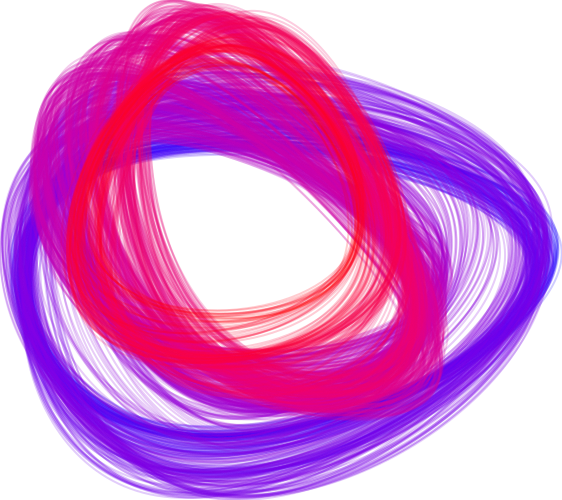

In [69]:
let initialLoop = ColorLoop { points = triangle 70, colorBlend = 0 }
 in sampleAndDraw 2 $ mconcat . map draw  <$> evolution 1000 initialLoop

## Color Lines

In [71]:
data ColorLine = ColorLine { points :: [P2 Double]
                           , colorBlend :: Double }

instance Drawable ColorLine where
  draw cl = cubicSpline False (points cl) # lcA color # lw 2
    where color = blend (colorBlend cl) blue yellow `withOpacity` 0.2
  
instance Living ColorLine where
  evolve cl = do
    let len = length $ points cl
    deltas <- replicateM len $ normal 0 1
    let offsets = zipWith (curry r2) (repeat 0) deltas
    return $ ColorLine { points = zipWith (.+^) (points cl) offsets
                       , colorBlend = colorBlend cl + 0.001 }

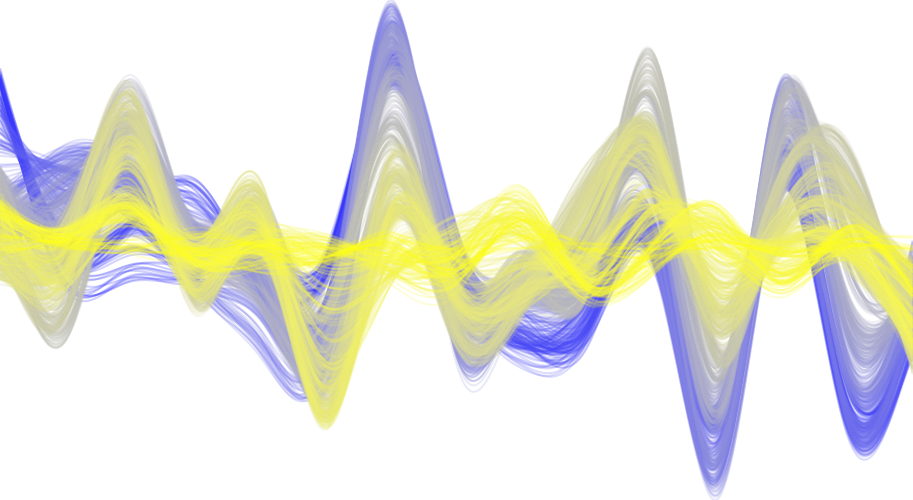

In [72]:
let initialLine = ColorLine { points = zipWith (curry p2) [0,15..] (replicate 15 0)
                            , colorBlend = 0 }
  in sampleAndDraw 1 $ mconcat . map draw  <$> evolution 1000 initialLine